In [1]:
# Installing necessary libraries
!pip install deepface
#!pip install glib
#!pip install albumentations

     |████████████████████████████████| 62 kB 571 kB/s 
     |████████████████████████████████| 2.3 MB 9.0 MB/s 


In [2]:
# Module / package imports
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import random
import numpy as np
import shutil
import requests
from PIL import Image
from io import BytesIO
from deepface import DeepFace

ROOT_DIR     = os.path.dirname(os.path.realpath("__file__"))
IMG_ROOT_DIR = os.path.join(ROOT_DIR, "dataset")

#                0    ,     1    ,      2      ,     3     ,      4      ,      5     ,     6    ,   7
BACKENDS = [  "opencv",     "ssd",       "dlib",    "mtcnn", "retinaface", "mediapipe"]
MODELS   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",   "DeepFace",    "DeepID", "ArcFace", "Dlib"]

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [3]:
from deepface.basemodels import VGGFace, OpenFace, Facenet, Facenet512,   \
                                FbDeepFace, DeepID, DlibWrapper, ArcFace, \
                                Boosting
from deepface.extendedmodels import Age, Gender, Race, Emotion
from deepface.commons import functions, realtime, distance as dst
from deepface.detectors import FaceDetector

import tensorflow as tf
tf_version = int(tf.__version__.split(".")[0])

if tf_version == 2:
	import logging
	tf.get_logger().setLevel(logging.ERROR)
	from tensorflow.keras.preprocessing import image
else:
  from keras.preprocessing import image

# ==============================================================================

def detect_faces(img_path, target_size = (224, 224), grayscale = False,
                 detector_backend = 'opencv', align = True,
                 return_type='both'):
  """
  Detects faces in an image (and optionally aligns them).
    
  Inputs:
    1. img_path - image path, base64 image or numpy array image
    2. target_size - size of the output face images. Irrelevant if
      return_type='regions' ([target_size=(224, 224)]).
    3. grayscale - flag to indicate if image is grayscale.
    4. detector_backend - string corresponding to detector ([opencv],
      ssd, dlib, mtcnn, retinaface, mediapipe).
    5. align - flag indicating if face should be aligned ([align=True]).
    6. return_type - string indicating if faces, regions or both should
      be returned ('faces', 'regions', ['both']).
            
  Outputs:
    If return_type='regions':
      Dictionary containing list of face detections. The face detections
      (or regions of interest - rois) are lists with the format
      [top-left x, top-left y, width, height]. The dictionary key is
      'regions'.
            
    If return_type='faces':
      Dictionary containing list of detected faces. Each detection is an
      image with 'target_size' size (the number of color channels is
      unchanged). The dictionary key is 'faces'.
            
    If return_type='both':
      Dictionary containing both of the above outputs: face detections and
      detected faces. The dictionary keys are 'faces' and 'regions'. 
    
  Example call:
    output = detect_faces(img_path, target_size = (224, 224), grayscale = False,
      detector_backend = 'opencv', align = True, return_type='both')
    
  """
    
  # Loads image. Image might be path, base64 or numpy array. Convert it to numpy
  # whatever it is.
  img = functions.load_image(img_path)

  # The detector is stored in a global variable in FaceDetector object.
  # This call should be completed very fast because it will return found in
  # memory and it will not build face detector model in each call (consider for
  #loops)
  face_detector = FaceDetector.build_model(detector_backend)
  detections    = FaceDetector.detect_faces(face_detector, detector_backend, 
                                            img, align)

  # Raises an error if not faces were found
  if len(detections) == 0:
    raise ValueError("Face could not be detected. Please confirm that the \
                      picture is a face photo.")

  # Raises an error if return type is not 'faces', 'regions' or 'both'.
  # Otherwise, initializes lists.
  if return_type == "faces" or return_type == "regions" or \
     return_type == "both":
    faces = []
    rois  = []
  else:
    raise ValueError("Return type should be 'faces', 'regions' or 'both'.")

  # Loops through each face & region pair
  for face, roi in detections:
    # Only process images (faces) if the return type is 'faces' or 'both'
    if return_type == "faces" or return_type == "both":
      # Ensures that both dimensions are >0
      if face.shape[0] == 0 or face.shape[1] == 0:
        raise ValueError(f"Detected face shape is {img.shape}.")

      # Converts to grayscale
      if grayscale == True:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                
                
      if face.shape[0] > 0 and face.shape[1] > 0:
        factor_0 = target_size[0] / face.shape[0]
        factor_1 = target_size[1] / face.shape[1]
        factor   = min(factor_0, factor_1)

        dsize = (int(face.shape[1] * factor), int(face.shape[0] * factor))
        face = cv2.resize(face, dsize)

        # Then pad the other side to the target size by adding black pixels
        diff_0 = target_size[0] - face.shape[0]
        diff_1 = target_size[1] - face.shape[1]
                
        if grayscale == False:
          # Put the base image in the middle of the padded image
          face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                               (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)),
                               'constant')
        else:
          face = np.pad(face, ((diff_0 // 2, diff_0 - diff_0 // 2),
                               (diff_1 // 2, diff_1 - diff_1 // 2)),
                               'constant')

      # Double check if target image is not still the same size with target.
      if face.shape[0:2] != target_size:
        face = cv2.resize(face, target_size)

      # Normalizing the image pixels
      face = image.img_to_array(face) #what this line doing? must?
      face = np.expand_dims(face, axis = 0)
      face /= 255 # normalize input in [0, 1]

      # Appends processed face
      faces.append(face)
        
    
    # Only process regions (rois) if the return type is 'regions' or 'both'
    if return_type == "regions" or return_type == "both":
      rois.append(roi)

  if return_type == "faces":
    return {"faces":faces}
  elif return_type == "regions":
    return {"regions":rois}
  else:
    assert return_type == "both", "Return type should be 'both' here."
    return {"faces":faces, "regions":rois}

# ==============================================================================

def show_batch_images(img_paths, num=1, start=0, shuffle=False):
    """
    Plots a batch of 'num' images from the list 'img_paths' which
    contains the full path to each image. Starts from 'start' image.
    If 'shuffle' is True, then the 'img_paths' list is shuffled first.
    
    Inputs:
        1. img_paths - list containing full path to each image
        
        2. num - number of images to be shown ([num=1])
        
        3. start - start from 'start' image ([start=0])
        
        4. shuffle - shuffles the image paths list ([shuffle=False])
        
    Output:
      None
      
    Example calls:
        show_batch_images(paths, num=4, start=2)
        show_batch_images(paths, num=3, shuffle=True)
        
    """
    if num <= 0:
        num = 1
    
    if shuffle:
        random.shuffle(img_paths)
    
    assert len(img_paths[start]) >= num, "Not enough images."
    
    for i, path in enumerate(img_paths[start:]):
        if i >= num:
            break
        
        plt.imshow(mpimg.imread(path))
        plt.title(path.split("/")[-1])
        plt.show()

# ==============================================================================

def plot_face_detections(img_path, rois, figsize = (8, 6),
                         linewidth=1, edgecolor='r'):
    """
    Plots the original image with the face detections overlaid as red
    rectangles.
    
    Inputs:
        1. img_path - image path, base64 image or image as a numpy array.
        2. rois - list of region of interests ([top-left x, top-left y, width,
            height])
        3. figsize - 2 element tupple specifying figure size
           ([figsize = (8, 6)])
        4. linewidth - positive number specifying the line width
           ([linewidth = 1])
        5. edgecolor - character specifying the rectangles' color
           ([edgecolor = 'r'])
        
    Output:
        1. fig - handle to the plotted figure
        
    Example call:
        fig = plot_face_detections(img_path, rois)
    """
    
    # Loads image. Image might be path, base64 or numpy array.
    # Convert it to numpy whatever it is.
    img = functions.load_image(img_path)
    
    # Plot figure
    fig, ax = plt.subplots(1, figsize = figsize)
    plt.imshow(img)
    
    # Loops through each region of interest (roi) and plots
    # it over the original image
    for roi in rois:
        # Skip region plotting if no faces were detected
        if len(roi) == 0:
            continue
        
        rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                                 linewidth = linewidth, edgecolor = edgecolor,
                                 facecolor='none')
        ax.add_patch(rect)
        
    return fig

# ==============================================================================

# Create directory function
def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Example call:
    status = create_dir("./this/is/a/directory/path")
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ==============================================================================

def plot_FR_results(original_image_path, results, figsize=(8, 8)):
  """
  Plots the results of the face recognition dataframe. The original image is 
  displayed along with all other matching images found in the dataset.

  Inputs:
    1. original_image_path - path to the original (target) image
    2. results - dataframe containing the results of the face recognition system
    3. figsize - 2 element tuple specifying the plotting size in inches
       ([figsize=(8, 8)])

  Output:
    1. handle to the plotted figure

  Example call:
    plot_FR_results(original_image_path, results, figsize=(8, 8)
  """
  # Determines the 'grid shape' of the plots. If there are less than 4 images,
  # plot them as a single column. Otherwise, plots them as a M x 2 grid.
  n = len(results.index) + 1

  if n < 4:
    n_col = 1
    n_row = n
  else:
    n_col = 2
    n_row = np.ceil(n / 2).astype(int)

  # Transforms the resulting image paths and metrics into lists
  rimgs   = list(results.iloc[:, 0])
  metrics = list(results.iloc[:, 1])

  # Plotting sequence:
  # Creates an array of axis and flattens it
  fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
  axs = axs.flatten()

  # Loops through each axis
  for i, ax in enumerate(axs):
    # Case 1: Plots the original image
    if i == 0:
      ax.imshow(mpimg.imread(original_image_path))
      ax.set_title("Original image {}".format(
          original_image_path.split('/')[-1]))

    # Case 2: Plots the database image that matches the recognized person
    elif i < n:
      ax.imshow(mpimg.imread(rimgs[i-1]))
      ax.set_title("DB match: {:s} (metric: {:.4f})".format(
          rimgs[i-1].split('/')[-1], metrics[i-1]))

    # Otherwise: Does not plot anything (just a placeholder)
    else:
      #ax.set_title("Placeholder (ignore)")
      pass
  
  # Shows plot and returns figure handle
  plt.show()
  return fig

# Data set setup and exploration
Since we are in Colab and there is no good way to get a simple data set, we first clone the 'deepface' repo, extract its small data set and then delete everything else. Once this process is done, we will have a small data set at *'./dataset/'*.

Then, we use the *show_batch_images* function to show X random images, so that we get an idea of what to expect. This small data set consists of random famous / well-known people and, therefore, is extremely biased: most subjects are white male or females.

In [4]:
# Setting the data set up
if not os.path.isdir(IMG_ROOT_DIR):
  !git clone https://github.com/serengil/deepface

  # Moves the dataset from 'deepface' repo
  try:
    shutil.move('./deepface/tests/dataset/', IMG_ROOT_DIR)
  except FileNotFoundError:
    print('Expected dataset to be in "./deepface/tests/dataset/". \
          Attempting to continue...')
    pass

  # Deletes the repo - we just needed the data set
  try:
    shutil.rmtree('./deepface/')
  except FileNotFoundError:
    print('Expected to find deepface repo in "./deepface/". \
          Attempting to continue...')
    pass

else:
  print(f"Dataset located in {IMG_ROOT_DIR}")

Cloning into 'deepface'...
remote: Enumerating objects: 2849, done.
remote: Counting objects: 100% (608/608), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 2849 (delta 508), reused 451 (delta 449), pack-reused 2241
Receiving objects: 100% (2849/2849), 42.29 MiB | 29.66 MiB/s, done.
Resolving deltas: 100% (1771/1771), done.


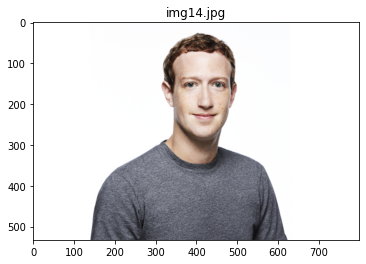

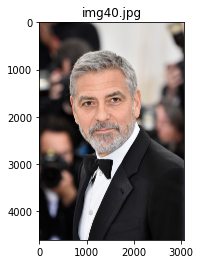

In [5]:
# showing X examples of the data set
SHOW_X_EXAMPLES = 2

# Obtain all image paths
img_paths = [os.path.join(IMG_ROOT_DIR, path) for path \
             in os.listdir(IMG_ROOT_DIR) if path.startswith("img") \
             and path.endswith(".jpg")]

# Show a batch of images
show_batch_images(img_paths, num=SHOW_X_EXAMPLES, shuffle=True)
img_paths.sort() # sorts after shuffle

# Face detection

We define a target image and use a chosen face detector to detect the faces in it. There are 6 types of face detectors: opencv, ssd, dlib, mtcnn, retinaface, mediapipe. The face region is shown as a red rectangle over the original image and the cropped (and aligned) face is also shown.

A second example is provided in which the performance (accuracy) of each face detector available is shown. Note that currently 'mediapipe' is bugged for some reason - says it is not a valid detector despite that not being true.

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 97.0MB/s]


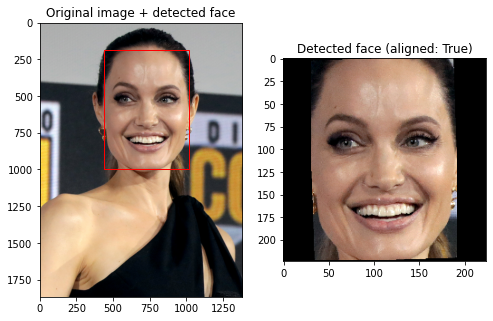

In [6]:
# First example: single face detection

# Define the target image - this can be changed
TARGET_IMG = img_paths[0]

# Detects faces
output = detect_faces(TARGET_IMG, target_size = (224, 224),
                      detector_backend = BACKENDS[4], align = True,
                      return_type='both')

# Plotting sequence
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(mpimg.imread(TARGET_IMG))
axs[1].imshow(output["faces"][0][0, :, :, ::-1])

# Add rectangle to identify face area
roi  = output["regions"][0]
rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                         linewidth=1, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)

# Add title
axs[0].title.set_text("Original image + detected face")
axs[1].title.set_text("Detected face (aligned: True)")

deploy.prototxt will be downloaded...


Downloading...
From: https://github.com/opencv/opencv/raw/3.4.0/samples/dnn/face_detector/deploy.prototxt
To: /root/.deepface/weights/deploy.prototxt
28.1kB [00:00, 25.2MB/s]                   


res10_300x300_ssd_iter_140000.caffemodel will be downloaded...


Downloading...
From: https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
To: /root/.deepface/weights/res10_300x300_ssd_iter_140000.caffemodel
100%|██████████| 10.7M/10.7M [00:00<00:00, 116MB/s]
Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2


shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


100%|██████████| 5.71M/5.71M [00:00<00:00, 15.2MB/s]


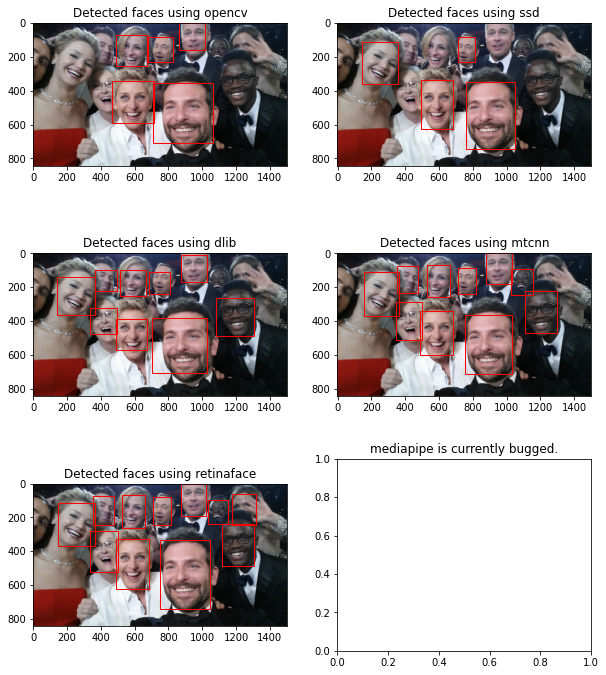

In [7]:
# Second example: multiple face detection
# Note that this URL below can be changed to some other picture with multiple
# faces
FILE_URL = "https://img.playbuzz.com/image/upload/c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_2.5/v1529570769/myuuxslhz7udhdxj0ihh.jpg"

# Obtain image
r   = requests.get(FILE_URL)
img = Image.open(BytesIO(r.content))

# Create array of axes corresponding to a 2 x 2 grid
fig2, axs = plt.subplots(3, 2, figsize=(10, 12));
axs = [item for ax_list in axs for item in ax_list]

outputs = []
for i in range(6):
    if i == 5:
        axs[i].title.set_text(f"{BACKENDS[i]} is currently bugged.")
        continue
    
    # Detects faces (regions)
    output = detect_faces(img_path=FILE_URL,
                          target_size=(224, 224),
                          detector_backend=BACKENDS[i],
                          return_type='regions')
    outputs.append(output['regions'])
    
    # Plots image
    axs[i].imshow(img)

    for roi in outputs[i]:
        # Skip region plotting if no faces were detected
        if len(roi) == 0:
            continue
        
        # Draw and plot rectangle
        rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                                 linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)
    
    axs[i].title.set_text(f"Detected faces using {BACKENDS[i]}")

# Face verification

We compare a target image to a reference image and determine if they are the same person. The face detector and verifier models are also shown. The main difference between face verification and recognition, at this stage, is that the face recognition requires runing the face verifier across a set (database) of images. 

facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 78.7MB/s]


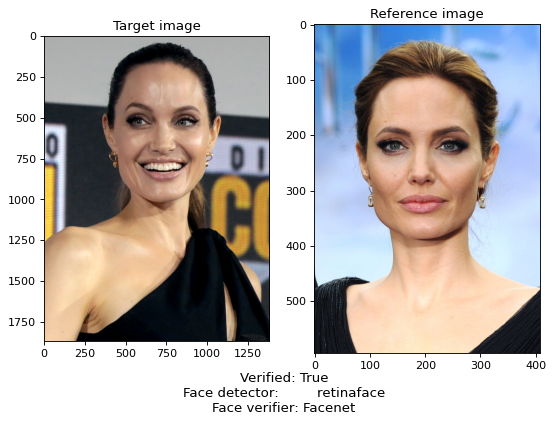

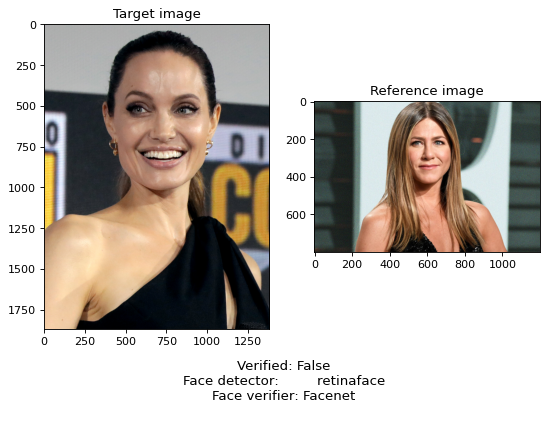

In [8]:
# Setting target and test images - these can be changed
TARGET_IMG = img_paths[0]
REF_IMG1   = img_paths[1]  # positive match with target
REF_IMG2   = img_paths[50] # negative match with target

USE_BACKEND = BACKENDS[4]
USE_MODEL   = MODELS[1]

# Runs verification
pos_verification = DeepFace.verify(img1_path = TARGET_IMG, img2_path = REF_IMG1,
                                   model_name = USE_MODEL,
                                   detector_backend = USE_BACKEND)
neg_verification = DeepFace.verify(img1_path = TARGET_IMG, img2_path = REF_IMG2,
                                   model_name = USE_MODEL,
                                   detector_backend = USE_BACKEND)

# Plotting sequences
fig1, axs1 = plt.subplots(1, 2, figsize=(8, 6), dpi=80)
axs1[0].imshow(mpimg.imread(TARGET_IMG))
axs1[0].title.set_text("Target image")

axs1[1].imshow(mpimg.imread(REF_IMG1))
axs1[1].title.set_text("Reference image")

# Add text
txt1 = f"Verified: {pos_verification['verified']}\nFace detector: \
        {USE_BACKEND}\nFace verifier: {pos_verification['model']}\n"
plt.figtext(0.5, 0.01, txt1, wrap=True, horizontalalignment='center', 
            fontsize=12);

# Plotting sequence
fig2, axs2 = plt.subplots(1, 2, figsize=(8, 6), dpi=80)
axs2[0].imshow(mpimg.imread(TARGET_IMG))
axs2[0].title.set_text("Target image")

axs2[1].imshow(mpimg.imread(REF_IMG2))
axs2[1].title.set_text("Reference image")

# Add text
txt2 = f"Verified: {neg_verification['verified']}\nFace detector: \
        {USE_BACKEND}\nFace verifier: {neg_verification['model']}\n"
plt.figtext(0.5, 0.01, txt2, wrap=True, horizontalalignment='center', 
            fontsize=12);

# Facial attribute analysis

Face attribute analysis is the extraction of information by analysing the face. More specifically, here we are trying to determine the age, gender, race and emotion of the person in the target image from their face alone. The attributes are shown along with the original image with the face region overlaid on top. The race and emotions shown are the dominant ones, that is, the most likely one.

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 83.3MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:22<00:00, 24.0MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:07<00:00, 70.3MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:06<00:00, 89.4MB/s]
Action: emotion: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


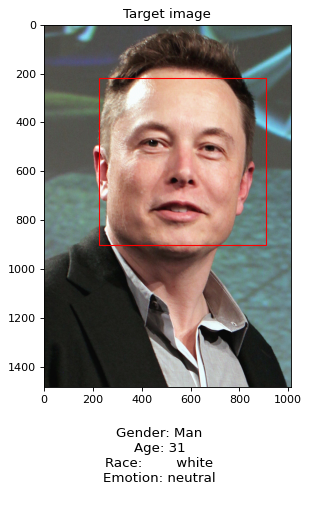

In [9]:
# Setting target image
TARGET_IMG = img_paths[10]

# Run age, gender, race and emotion analysis
obj = DeepFace.analyze(img_path = TARGET_IMG,
                       actions = ['age', 'gender', 'race', 'emotion'])

# Plotting sequence
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=80)
ax.imshow(mpimg.imread(TARGET_IMG))
ax.title.set_text("Target image")

# Add rectangle to identify face area
rect = patches.Rectangle((obj['region']['x'], obj['region']['y']),
                          obj['region']['w'], obj['region']['h'],
                          linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Add text
txt = f"Gender: {obj['gender']}\nAge: {obj['age']}\nRace: \
       {obj['dominant_race']}\nEmotion: {obj['dominant_emotion']}\n"
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center',
            fontsize=12);

# Face Recognition

We first clone the previous dataset and split it into two subsets: database and wild. The 'database' partition simulates a face database we might have available to us. The 'wild' partition simulates a face obtained "somewhere" which we wish to compare to our database. The first cell builds this new dataset for facial recognition.

Then, we run the facial recognition system and plot the results: the original (wild) face and ALL faces matched in our dataset (which should belong to the same person, obviously). Note that you can use different faces to test the facial recognition system, as long as they are in the 'wild' directory (see cell below).

Note: you can run this without a GPU but the default example (Angelina Jolie) took around 213 seconds (that's 3.55 minutes).

In [10]:
# Splitting data into a ficticious database and 'wild' faces
database = {
  "Angelina": ["img7.jpg", "img10.jpg", "img11.jpg"],
  "Scarlett": ["img49.jpg", "img50.jpg", "img51.jpg"],
  "Jennifer": ["img54.jpg", "img55.jpg", "img56.jpg"],
  "Mark":     ["img15.jpg", "img57.jpg", "img58.jpg"],
  "Jack":     ["img59.jpg", "img61.jpg", "img62.jpg"],
  "Elon":     ["img67.jpg"],
  "Jeff":     ["img21.jpg"],
  "Marissa":  ["img23.jpg"],
  "Sundar":   ["img25.jpg"],
  "Katy":     ["img44.jpg", "img45.jpg", "img46.jpg"],
  "Matt":     ["img31.jpg", "img32.jpg", "img33.jpg"],
  "Leonardo": ["img36.jpg", "img37.jpg"],
  "George":   ["img40.jpg", "img41.jpg"]
}

# Wild dictionary
wild = {
  "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg", "img5.jpg", "img6.jpg"],
  "Scarlett": ["img8.jpg", "img9.jpg", "img47.jpg", "img48.jpg"],
  "Jennifer": ["img3.jpg", "img12.jpg", "img53.jpg"],
  "Mark":     ["img13.jpg", "img14.jpg"],
  "Jack":     ["img16.jpg", "img17.jpg"],
  "Elon":     ["img18.jpg", "img19.jpg"],
  "Jeff":     ["img20.jpg"],
  "Marissa":  ["img22.jpg"],
  "Sundar":   ["img24.jpg"],
  "Katy":     ["img26.jpg", "img27.jpg", "img28.jpg", "img42.jpg", "img43.jpg"],
  "Matt":     ["img29.jpg", "img30.jpg"],
  "Leonardo": ["img34.jpg", "img35.jpg"],
  "George":   ["img38.jpg", "img39.jpg"]
}

# Clones the small dataset (so that running this part of the demo does not break
# the previous ones xD), creates two new directories in it: 'database' and
# 'wild' and moves the relevant files into the appropriate subdirectories
FR_DATASET_DIR = os.path.join(ROOT_DIR, "fr_dataset")
FR_DB_DIR      = os.path.join(FR_DATASET_DIR, "database")
FR_WD_DIR      = os.path.join(FR_DATASET_DIR, "wild")

print("Preparing dataset ...", end=" ")
try:
  shutil.copytree(IMG_ROOT_DIR, FR_DATASET_DIR) # clones dataset
  create_dir(FR_DB_DIR)                         # creates 'database' directory
  create_dir(FR_WD_DIR)                         # creates 'wild' directory

  # Moves files into the appropriate subdirectories
  for i in range(2):
    if i == 0:
      target = database
      tpath  = FR_DB_DIR
    else:
      target = wild
      tpath  = FR_WD_DIR

    # Flattens dictionary into list
    file_names = [item for sublist in list(target.values()) \
                  for item in sublist]

    # Moves each file into the appropriate directory
    for name in file_names:
      try:
        shutil.move(os.path.join(FR_DATASET_DIR, name),
                    os.path.join(tpath, name))
      except FileExistsError:
        print(f"File: {os.path.join(FR_DATASET_DIR, name)} \
               does not exist but should!")

  print("done!")

except OSError:
  print("failed! (directory already exists)")


Preparing dataset ... done!


Representations stored in  /content/fr_dataset/database / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  70.30397844314575  seconds
                                 identity  Facenet_cosine
0   /content/fr_dataset/database/img7.jpg        0.203843
1  /content/fr_dataset/database/img10.jpg        0.220001
2  /content/fr_dataset/database/img11.jpg        0.220249 




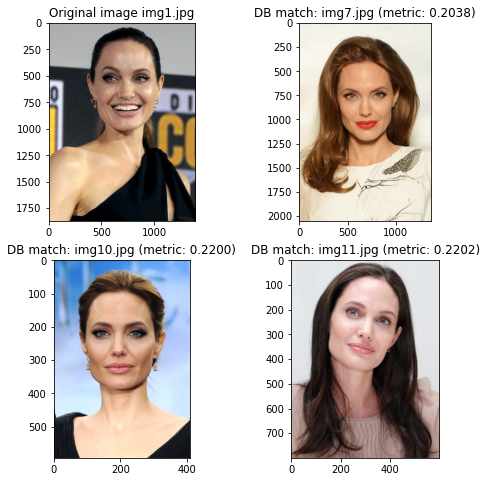

In [11]:
# You can edit these parameters! To chose a different face for recognition,
# change the 'USE_WILD_FACE' parameter. For available options, refer to the
# 'wild' dictionary (in the cell above)
USE_WILD_FACE = wild["Angelina"][0]
USE_BACKEND = BACKENDS[4]
USE_MODEL   = MODELS[1]

# Compares the face against the database (took 212.87 s without CPU)
df = DeepFace.find(img_path = os.path.join(FR_WD_DIR, USE_WILD_FACE),
                   db_path = FR_DB_DIR, model_name = USE_MODEL,
                   detector_backend = USE_BACKEND)

print(df, "\n"*2, "="*100, "\n")

# Plots results
plot_FR_results(os.path.join(FR_WD_DIR, USE_WILD_FACE), df);